# Data Cleaning and Preprocessing Pipeline for Machine Learning Model

## Σύνοψη Διαδικασίας

Αυτό το notebook υλοποιεί μια ολοκληρωμένη διαδικασία καθαρισμού και προετοιμασίας δεδομένων για την ανάπτυξη ενός μοντέλου μηχανικής μάθησης (Machine Learning). Τα δεδομένα προέρχονται από πειραματικές μελέτες που αφορούν την αποτελεσματικότητα φαρμακευτικών ουσιών σε διάφορες κυτταρικές σειρές καρκίνου. Ο κύριος στόχος είναι η πρόβλεψη της τιμής **`t.bliss_window`**, που αποτελεί μέτρο της συνεργιστικής δράσης φαρμάκων.

## Αρχική Φόρτωση και Διαχείριση Missing Values

Η διαδικασία ξεκινά με τη φόρτωση του αρχείου `model_dataset_compressed_v4.csv`, το οποίο έχει υποστεί προεπεξεργασία στο Excel. Συγκεκριμένα, έχει αφαιρεθεί η στήλη `gene_id` και έχουν αντικατασταθεί οι λίστες που περιείχαν NaN values με το placeholder string "needs replacement". Αυτή η προσέγγιση ήταν απαραίτητη επειδή η Python δυσκολευόταν να αναγνωρίσει αυτοματικά τα NaN values μέσα σε λίστες λόγω του format αποθήκευσης στο CSV αρχείο.

Αφού φορτωθούν τα δεδομένα, το πρώτο βήμα καθαρισμού είναι η αναγνώριση και αντικατάσταση όλων των εμφανίσεων του string "needs replacement" με πραγματικές NaN τιμές (pd.NA). Αυτό επιτυγχάνεται με συστηματική αναζήτηση σε όλες τις στήλες του DataFrame, καταγράφοντας πόσες εμφανίσεις υπάρχουν ανά στήλη. Η μετατροπή αυτή είναι κρίσιμη για την ορθή στατιστική ανάλυση και επεξεργασία που ακολουθεί.

## Στρατηγική Imputation για Αριθμητικές Μεταβλητές

Για τη διαχείριση των NaN τιμών στις αριθμητικές στήλες, χρησιμοποιείται η τεχνική του **median imputation**. Συγκεκριμένα, πέντε στήλες που σχετίζονται με πειραματικές μετρήσεις (`t.day1_inhibition_scale`, `t.day1_intensity_mean`, `t.day1_viability_mean`, `t.doubling_time`, `t.growth_rate`) παρουσιάζουν missing values. Για κάθε μία από αυτές τις στήλες, υπολογίζεται η διάμεσος (median) των υπαρχόντων τιμών, και στη συνέχεια τα NaN values αντικαθίστανται με αυτήν την τιμή.

Η επιλογή του median αντί του mean (μέσου όρου) είναι συνειδητή και στρατηγική. Το median είναι πιο robust στην παρουσία ακραίων τιμών (outliers), πράγμα που αναμένεται σε βιολογικά δεδομένα όπου μπορεί να υπάρχουν πειραματικά σφάλματα ή φυσιολογική βιολογική διακύμανση. Πριν από τη συμπλήρωση, οι στήλες μετατρέπονται σε αριθμητικό τύπο με τη χρήση του `pd.to_numeric()` με την παράμετρο `errors='coerce'`, ώστε να διασφαλιστεί ότι τυχόν μη-αριθμητικές τιμές θα μετατραπούν σε NaN.

## Μετασχηματισμός Λιστών TPM Values

Μια από τις πιο σημαντικές μετατροπές αφορά τη στήλη `tpm_value` (Transcripts Per Million), η οποία περιέχει λίστες αριθμητικών τιμών που αντιπροσωπεύουν την έκφραση πολλαπλών γονιδίων. Για να μπορέσουμε να χρησιμοποιήσουμε αυτά τα δεδομένα σε ένα μοντέλο μηχανικής μάθησης, πρέπει να μετατραπεί κάθε λίστα σε μια μόνο αριθμητική τιμή.

Η προσέγγιση που υιοθετείται είναι η εξαγωγή του **median** κάθε λίστας. Αυτό γίνεται με τη δημιουργία βοηθητικών συναρτήσεων: η `to_list_safe()` μετατρέπει με ασφάλεια strings που περιέχουν λίστες σε πραγματικές λίστες Python, ενώ η `list_median()` υπολογίζει το median των αριθμητικών στοιχείων. Η αρχική στήλη με τις λίστες αποθηκεύεται προσωρινά ως `tpm_value_raw` για backup, και η `tpm_value` αντικαθίσταται με τις median τιμές. Αργότερα, η στήλη backup αφαιρείται από το τελικό dataset.

## Εξερεύνηση Ακραίων Τιμών και Κατανομής

Πριν προχωρήσουμε στην κανονικοποίηση των δεδομένων, είναι απαραίτητο να κατανοήσουμε τη φύση της κατανομής τους. Για αυτό το λόγο, δημιουργούνται **boxplots** για κάθε αριθμητική στήλη, τα οποία επιτρέπουν την οπτική αναγνώριση outliers (ακραίων τιμών). Επιπλέον, για κάθε αριθμητική μεταβλητή δημιουργούνται:

1. **Histograms με Kernel Density Estimation (KDE)**: Αποκαλύπτουν το σχήμα της κατανομής και αν προσεγγίζει την κανονική κατανομή.
2. **Q-Q Plots (Quantile-Quantile Plots)**: Συγκρίνουν τα quantiles των δεδομένων με αυτά μιας θεωρητικής κανονικής κατανομής.

Για πιο επίσημο στατιστικό έλεγχο κανονικότητας, εφαρμόζεται το **Shapiro-Wilk test** σε κάθε στήλη. Το test αυτό ελέγχει την μηδενική υπόθεση ότι τα δεδομένα προέρχονται από κανονική κατανομή. Με κατώφλι σημαντικότητας α = 0.05, αν το p-value είναι μικρότερο από 0.05, απορρίπτουμε την κανονικότητα. Τα αποτελέσματα δείχνουν ότι οι περισσότερες μεταβλητές δεν ακολουθούν κανονική κατανομή, πράγμα που επηρεάζει την επιλογή της μεθόδου scaling.

## Scaling με RobustScaler

Δεδομένου ότι τα δεδομένα δεν είναι κανονικά κατανεμημένα και υπάρχουν outliers, η κλασική StandardScaler (που υποθέτει κανονική κατανομή) δεν είναι η βέλτιστη επιλογή. Αντί αυτού, χρησιμοποιείται ο **RobustScaler** από το scikit-learn, ο οποίος:

- Αφαιρεί τη διάμεσο (median) αντί για τον μέσο όρο
- Διαιρεί με το Interquartile Range (IQR = Q3 - Q1) αντί για την τυπική απόκλιση
- Είναι εξαιρετικά ανθεκτικός σε outliers

Ο μετασχηματισμός αυτός διασφαλίζει ότι όλες οι αριθμητικές μεταβλητές βρίσκονται σε παρόμοια κλίμακα, κάτι που είναι απαραίτητο για αλγόριθμους που βασίζονται σε αποστάσεις (π.χ. KNN, Neural Networks) ή έχουν regularization terms. Το αποτέλεσμα αποθηκεύεται σε ένα νέο DataFrame `df_scaled`.

## Διαχείριση Κατηγορικών Μεταβλητών

Το dataset περιέχει τρεις σημαντικές κατηγορικές μεταβλητές: `cellline_name` (όνομα κυτταρικής σειράς), `cancer_type` (τύπος καρκίνου), και `c.tissue` (ιστός προέλευσης). Πριν την κωδικοποίηση, εξετάζεται η cardinality (πλήθος μοναδικών κατηγοριών) κάθε μεταβλητής, καθώς αυτό επηρεάζει την επιλογή της κατάλληλης τεχνικής encoding.

Για τις μεταβλητές `cancer_type` και `c.tissue`, που έχουν μέτριο πλήθος κατηγοριών, εφαρμόζεται **One-Hot Encoding**. Αυτή η τεχνική δημιουργεί νέες δυαδικές (0/1) στήλες, μία για κάθε κατηγορία. Χρησιμοποιείται η παράμετρος `drop_first=True` για να αποφευχθεί το πρόβλημα της multicollinearity (γραμμικής εξάρτησης), αφού μία κατηγορία μπορεί να συναχθεί από τις υπόλοιπες.

Για τη μεταβλητή `cellline_name`, που έχει πολύ μεγάλο πλήθος μοναδικών τιμών (πλησιάζει τον αριθμό των παρατηρήσεων), το One-Hot Encoding θα δημιουργούσε εκατοντάδες νέες στήλες, οδηγώντας σε **curse of dimensionality**. Αντί αυτού, χρησιμοποιείται **Target Encoding** μέσω της βιβλιοθήκης category_encoders. Αυτή η τεχνική αντικαθιστά κάθε κατηγορία με τον μέσο όρο της target μεταβλητής (`t.bliss_window`) για εκείνη την κατηγορία. 

Ωστόσο, υπάρχει μια σημαντική σημείωση στον κώδικα: λόγω του υψηλού πλήθους κατηγοριών σε σχέση με τις παρατηρήσεις, υπάρχει κίνδυνος **overfitting**. Κάθε cellline μπορεί να έχει ελάχιστες παρατηρήσεις, οπότε ο target-encoded τιμή μπορεί να μην είναι αντιπροσωπευτική αλλά να "απομνημονεύει" συγκεκριμένα δείγματα.

## Τελικές Προετοιμασίες και Εξαγωγή

Πριν την εξαγωγή του καθαρισμένου dataset, αφαιρούνται στήλες που δεν χρειάζονται για το μοντέλο αλλά χρησίμευαν για reference κατά τη διαδικασία καθαρισμού: `trial_id`, `gene_name`, `pathway_name`, και `drug_targeting_pathway`. Επίσης αφαιρείται η στήλη `tpm_value_raw` που περιείχε τις αρχικές λίστες TPM values πριν από το aggregation.

Το τελικό DataFrame αποθηκεύεται στο αρχείο **`df_ml_model.csv`**, έτοιμο για χρήση σε αλγόριθμους μηχανικής μάθησης. Το dataset περιέχει:
- Scaled αριθμητικές μεταβλητές (robust στα outliers)
- One-hot encoded κατηγορικές μεταβλητές χαμηλής cardinality
- Target encoded κατηγορική μεταβλητή υψηλής cardinality
- Καμία missing value
- Την target μεταβλητή `t.bliss_window` ανέπαφη για επιβλεπόμενη μάθηση

Η όλη διαδικασία αποτελεί ένα ολοκληρωμένο pipeline προετοιμασίας δεδομένων, που λαμβάνει υπόψη τόσο τη στατιστική φύση των δεδομένων όσο και τις απαιτήσεις των αλγορίθμων μηχανικής μάθησης.

In [1]:
import pandas as pd
import numpy as np
from py2neo import Graph
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as stats
from sklearn.preprocessing import RobustScaler
import category_encoders as ce
import ast

In [2]:
#Αν και στο προηγούμενο script τα δεδομένα ήταν v3, εδώ ανεβαίνουν ως v4.
#Locally στο excel έκανα drop το gene_id column.
#Επίσης όπου υπήρχαν λίστες με nan values τις αντικατέστηστα με το 'needs replacement' string.
#Ώστε να τις διαχειριστούμε εδώ σαν nan τιμές, πριν η Python λόγω format δεν τις αναγνώριζε.

In [2]:
file_path= 'model_dataset_compressed_v4.csv'
df= pd.read_csv(file_path)
df.head(2)

,trial_id,t.bliss_window,t.combo_maxe,t.day1_inhibition_scale,t.day1_intensity_mean,t.day1_viability_mean,t.doubling_time,t.drug1_ic50_ln,t.drug1_maxe,t.drug2_ic50_ln,t.drug2_maxe,t.growth_rate,cellline_name,cancer_type,c.tissue,gene_name,tpm_value,pathway_name,drug_targeting_pathway
0,47199,0.070969,0.639282,0.555150906,5939.623377,0.444849094,63.85180142,1.239688,0.613071,3.863034,0.337226,1.127611099,42-MG-BA,Glioblastoma,Central Nervous System,"['ATR', 'WEE1', 'AURKB', 'ATM', 'BRCA2', 'ABRA...","[3.2494, 4.7317, 6.0498, 5.0904, 2.5484, 2.403...","['PI3K/MTOR signaling', 'Cell cycle']","['Palbociclib', 'Capivasertib']"
1,47226,0.031543,0.460323,0.059249023,19426.83442,0.940750977,839.3959358,2.562845,0.448569,2.320666,0.496414,0.085775969,ALL-SIL,T-Lymphoblastic Leukemia,Haematopoietic and Lymphoid,"['ATR', 'WEE1', 'AURKB', 'ATM', 'BRCA2', 'ABRA...","[4.3125, 6.0199, 7.8476, 4.9887, 3.8135, 1.922...","['PI3K/MTOR signaling', 'Cell cycle']","['Palbociclib', 'Capivasertib']"


In [3]:
#Εδώ βρίσκω που υπάρχουν εμφανίσεις του 'needs replacement' string, που σημαίνει ότι πρέπει να αντικατασταθούν.
# Μάσκα ακριβούς ταίριασματος (case-sensitive).
mask_exact = df.apply(lambda col: col == 'needs replacement')
counts_per_col = mask_exact.sum()

# Συνολικές εμφανίσεις
total_hits = counts_per_col.sum()

print('Συνολικές εμφανίσεις (exact match) του "needs replacement":', total_hits)
print('\nΑνά στήλη (μόνο όσες έχουν ≥1):')
print(counts_per_col[counts_per_col > 0].sort_values(ascending=False))


Συνολικές εμφανίσεις (exact match) του "needs replacement": 185

Ανά στήλη (μόνο όσες έχουν ≥1):
t.day1_inhibition_scale    37
t.day1_intensity_mean      37
t.day1_viability_mean      37
t.doubling_time            37
t.growth_rate              37
dtype: int64


In [4]:
#Αντικατάσταση του 'needs replacement' με NaN

before_total = (df == 'needs replacement').sum().sum()
print('Πλήθος εμφανίσεων πριν:', before_total)

# In-place αντικατάσταση (σε ΟΛΕΣ τις στήλες)
df.replace('needs replacement', pd.NA, inplace=True)

after_total = (df == 'needs replacement').sum().sum()
print('Πλήθος εμφανίσεων μετά:', after_total)

# Έλεγχος νέων NaN που προστέθηκαν ανά στήλη
nan_counts = df.isna().sum().sort_values(ascending=False)
print('\nNaN ανά στήλη (ταξινομημένα φθίνοντα):')
print(nan_counts)


Πλήθος εμφανίσεων πριν: 185
Πλήθος εμφανίσεων μετά: 0

NaN ανά στήλη (ταξινομημένα φθίνοντα):
t.day1_inhibition_scale    37
t.day1_intensity_mean      37
t.day1_viability_mean      37
t.doubling_time            37
t.growth_rate              37
trial_id                    0
cellline_name               0
pathway_name                0
tpm_value                   0
gene_name                   0
c.tissue                    0
cancer_type                 0
t.drug2_ic50_ln             0
t.drug2_maxe                0
t.bliss_window              0
t.drug1_maxe                0
t.drug1_ic50_ln             0
t.combo_maxe                0
drug_targeting_pathway      0
dtype: int64


In [5]:
# Υπολογισμός median για συγκεκριμένες στήλες στις οποιες εχω τα NaN
cols_target = [
    't.day1_inhibition_scale',
    't.day1_intensity_mean',
    't.day1_viability_mean',
    't.doubling_time',
    't.growth_rate'
]

# Έλεγχος ποια λείπουν
missing = [c for c in cols_target if c not in df.columns]
if missing:
    print('ΠΡΟΕΙΔΟΠΟΙΗΣΗ - Δεν βρέθηκαν οι στήλες:', missing)

existing = [c for c in cols_target if c in df.columns]

# Μετατροπή σε numeric όπου χρειάζεται (αν υπάρχουν strings) χωρίς να χαλάσουμε τις υπόλοιπες
for c in existing:
    if not pd.api.types.is_numeric_dtype(df[c]):
        df[c] = pd.to_numeric(df[c], errors='coerce')

nan_counts = df[existing].isna().sum()
medians = df[existing].median(numeric_only=True)

print('NaN ανά στήλη:')
print(nan_counts)
print('\nMedian ανά στήλη:')
print(medians)

# Παράδειγμα πρόσβασης: medians['t.growth_rate']


NaN ανά στήλη:
t.day1_inhibition_scale    37
t.day1_intensity_mean      37
t.day1_viability_mean      37
t.doubling_time            37
t.growth_rate              37
dtype: int64

Median ανά στήλη:
t.day1_inhibition_scale        0.569389
t.day1_intensity_mean      12874.657870
t.day1_viability_mean          0.430611
t.doubling_time               57.871426
t.growth_rate                  1.155422
dtype: float64


In [6]:
# Fill NaN τιμές με το median κάθε αριθμητικής στήλης

cols_target = [
    't.day1_inhibition_scale',
    't.day1_intensity_mean',
    't.day1_viability_mean',
    't.doubling_time',
    't.growth_rate'
]

# Αν δεν υπάρχει το αντικείμενο medians (π.χ. τρέχει κελί μόνο του), το ξαναϋπολογίζουμε
if 'medians' not in globals():
    existing = [c for c in cols_target if c in df.columns]
    for c in existing:
        if not pd.api.types.is_numeric_dtype(df[c]):
            df[c] = pd.to_numeric(df[c], errors='coerce')
    medians = df[existing].median(numeric_only=True)

existing_cols = [c for c in cols_target if c in df.columns]
missing_cols = [c for c in cols_target if c not in df.columns]
if missing_cols:
    print('Προσοχή - λείπουν στήλες:', missing_cols)

# Πριν
before_nan = df[existing_cols].isna().sum()

# Εφαρμογή fill μόνο όπου το median δεν είναι NaN
usable_medians = medians.dropna()
fillable = [c for c in existing_cols if c in usable_medians.index]

df[fillable] = df[fillable].fillna(usable_medians)

after_nan = df[existing_cols].isna().sum()

print('Σύνοψη:')
print('NaN πριν:')
print(before_nan)
print('\nNaN μετά:')
print(after_nan)

filled_counts = (before_nan - after_nan)
print('\nΚελιά που συμπληρώθηκαν ανά στήλη:')
print(filled_counts[filled_counts > 0])


Σύνοψη:
NaN πριν:
t.day1_inhibition_scale    37
t.day1_intensity_mean      37
t.day1_viability_mean      37
t.doubling_time            37
t.growth_rate              37
dtype: int64

NaN μετά:
t.day1_inhibition_scale    0
t.day1_intensity_mean      0
t.day1_viability_mean      0
t.doubling_time            0
t.growth_rate              0
dtype: int64

Κελιά που συμπληρώθηκαν ανά στήλη:
t.day1_inhibition_scale    37
t.day1_intensity_mean      37
t.day1_viability_mean      37
t.doubling_time            37
t.growth_rate              37
dtype: int64


In [7]:
#Τελικά κάνω drop το trial_id column που δεν χρειάζεται. Το κρατούσα έως τώρα κυρίως για τα τεστ μου.
df.drop(columns=['trial_id'], inplace=True)
df.head(2)

,t.bliss_window,t.combo_maxe,t.day1_inhibition_scale,t.day1_intensity_mean,t.day1_viability_mean,t.doubling_time,t.drug1_ic50_ln,t.drug1_maxe,t.drug2_ic50_ln,t.drug2_maxe,t.growth_rate,cellline_name,cancer_type,c.tissue,gene_name,tpm_value,pathway_name,drug_targeting_pathway
0,0.070969,0.639282,0.555151,5939.623377,0.444849,63.851801,1.239688,0.613071,3.863034,0.337226,1.127611,42-MG-BA,Glioblastoma,Central Nervous System,"['ATR', 'WEE1', 'AURKB', 'ATM', 'BRCA2', 'ABRA...","[3.2494, 4.7317, 6.0498, 5.0904, 2.5484, 2.403...","['PI3K/MTOR signaling', 'Cell cycle']","['Palbociclib', 'Capivasertib']"
1,0.031543,0.460323,0.059249,19426.834420,0.940751,839.395936,2.562845,0.448569,2.320666,0.496414,0.085776,ALL-SIL,T-Lymphoblastic Leukemia,Haematopoietic and Lymphoid,"['ATR', 'WEE1', 'AURKB', 'ATM', 'BRCA2', 'ABRA...","[4.3125, 6.0199, 7.8476, 4.9887, 3.8135, 1.922...","['PI3K/MTOR signaling', 'Cell cycle']","['Palbociclib', 'Capivasertib']"


In [8]:
#Μένει να μετατρέψω τη λίστα στη στήλη tpm_value σε median ανά γραμμή.

# Παραμετροποίηση:
INPLACE = True          # True => αλλάζει df_encoded_twice, False => δημιουργεί νέο df (df_tpm_median)
SOURCE_DF_NAME = 'df'
COLUMN_NAME = 'tpm_value'
NEW_DF_NAME = 'df_processed'# Όνομα νέου df αν INPLACE = False
ADD_MEDIAN_SUFFIX = False  # Αν True, κρατά και την αρχική λίστα και βάζει νέα στήλη <column>_median

# Ανάκτηση DataFrame από globals
if SOURCE_DF_NAME not in globals():
    raise NameError(f'Δεν βρέθηκε DataFrame με όνομα {SOURCE_DF_NAME}')
source_df = globals()[SOURCE_DF_NAME]

if COLUMN_NAME not in source_df.columns:
    raise KeyError(f'Η στήλη {COLUMN_NAME} δεν υπάρχει στο {SOURCE_DF_NAME}')

# Συναρτήσεις βοηθητικές
def to_list_safe(x):
    if isinstance(x, list):
        return x
    if pd.isna(x):
        return []
    if isinstance(x, (int, float)) and not pd.isna(x):
        return [x]
    if isinstance(x, str):
        s = x.strip()
        if s.startswith('[') and s.endswith(']'):
            try:
                parsed = ast.literal_eval(s)
                if isinstance(parsed, (list, tuple)):
                    return list(parsed)
            except Exception:
                return []
    return []

def list_median(seq):
    nums = [v for v in seq if isinstance(v, (int, float)) and not pd.isna(v)]
    return float(np.median(nums)) if nums else np.nan

print(f'Δείγμα πριν:')
print(source_df[COLUMN_NAME].head(3))

parsed_series = source_df[COLUMN_NAME].apply(to_list_safe)
median_series = parsed_series.apply(list_median)

if INPLACE:
    # Backup πρωτοτύπου
    backup_col = f'{COLUMN_NAME}_raw'
    if backup_col not in source_df.columns:
        source_df[backup_col] = source_df[COLUMN_NAME]
    if ADD_MEDIAN_SUFFIX:
        median_col = f'{COLUMN_NAME}_median'
        source_df[median_col] = median_series
    else:
        source_df[COLUMN_NAME] = median_series
    result_df = source_df
    result_name = SOURCE_DF_NAME
else:
    # Νέο DataFrame (πλήρες copy ή μόνο επιλεγμένες στήλες; εδώ πλήρες για ασφάλεια)
    result_df = source_df.copy()
    if ADD_MEDIAN_SUFFIX:
        result_df[f'{COLUMN_NAME}_median'] = median_series
    else:
        result_df[COLUMN_NAME] = median_series
    globals()[NEW_DF_NAME] = result_df
    result_name = NEW_DF_NAME

print('\nΜετατροπή ολοκληρώθηκε.')
print('Χρησιμοποιήθηκε INPLACE =', INPLACE)
print('Αποτέλεσμα σε DataFrame:', result_name)
print('NaN στη στήλη μετά:', result_df[COLUMN_NAME if not ADD_MEDIAN_SUFFIX else f'{COLUMN_NAME}_median'].isna().sum())
print('\nΔείγμα μετά:')
print(result_df[COLUMN_NAME if not ADD_MEDIAN_SUFFIX else f'{COLUMN_NAME}_median'].head(3))


Δείγμα πριν:
0    [3.2494, 4.7317, 6.0498, 5.0904, 2.5484, 2.403...
1    [4.3125, 6.0199, 7.8476, 4.9887, 3.8135, 1.922...
2    [4.5723, 4.3147, 7.1896, 4.8934, 2.4751, 3.783...
Name: tpm_value, dtype: object

Μετατροπή ολοκληρώθηκε.
Χρησιμοποιήθηκε INPLACE = True
Αποτέλεσμα σε DataFrame: df
NaN στη στήλη μετά: 0

Δείγμα μετά:
0    4.8824
1    5.3402
2    5.0796
Name: tpm_value, dtype: float64


In [9]:
print(df['tpm_value'])

0      4.88240
1      5.34020
2      5.07960
3      4.19930
4      5.55400
        ...   
848    4.49890
849    4.80580
850    4.72250
851    5.29485
852    5.29485
Name: tpm_value, Length: 853, dtype: float64


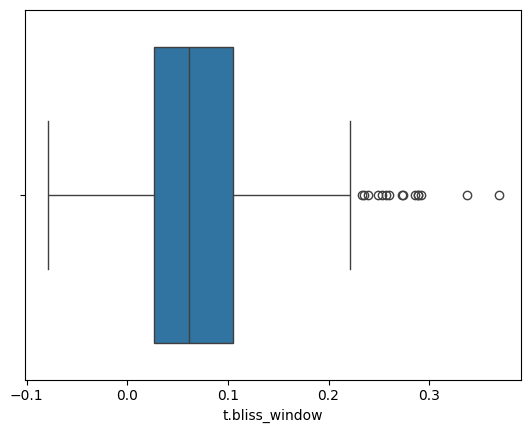

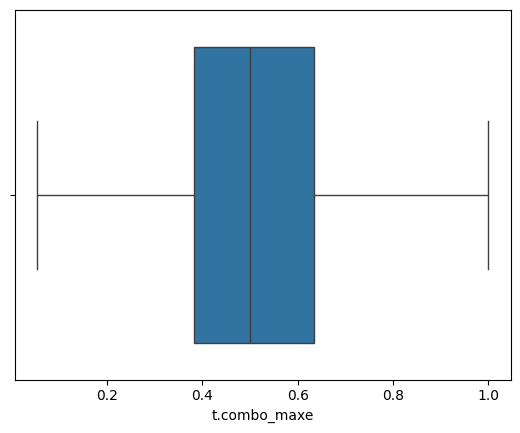

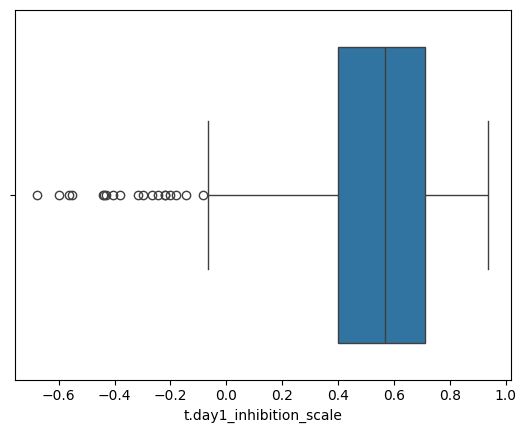

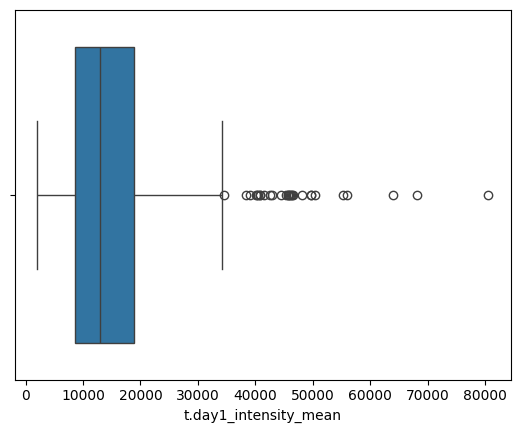

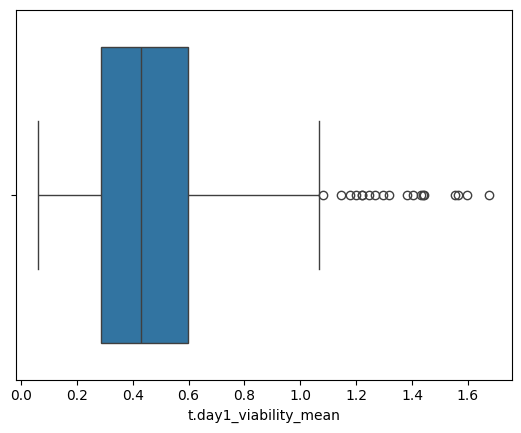

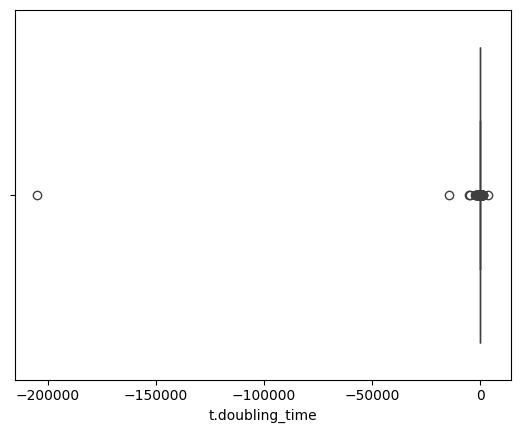

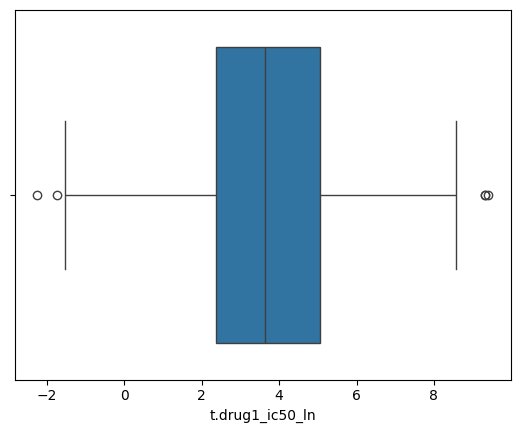

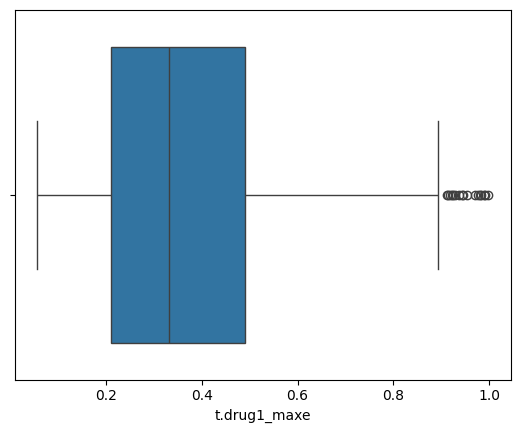

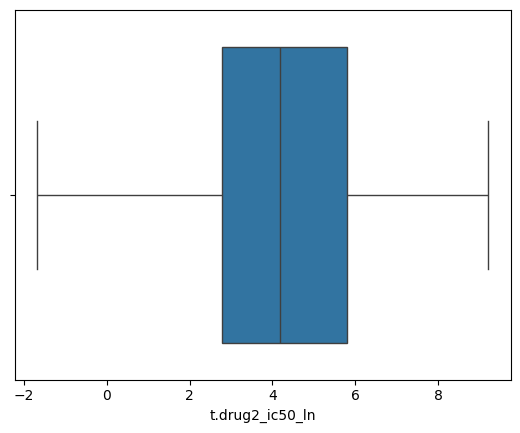

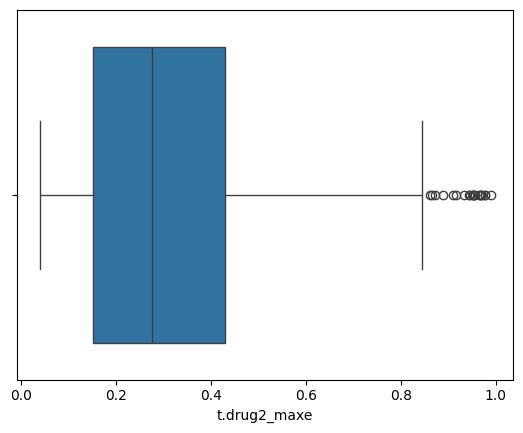

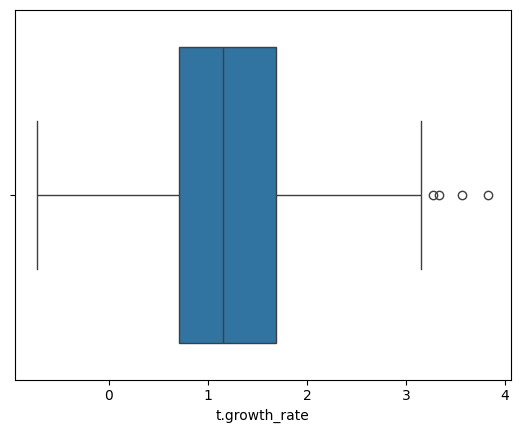

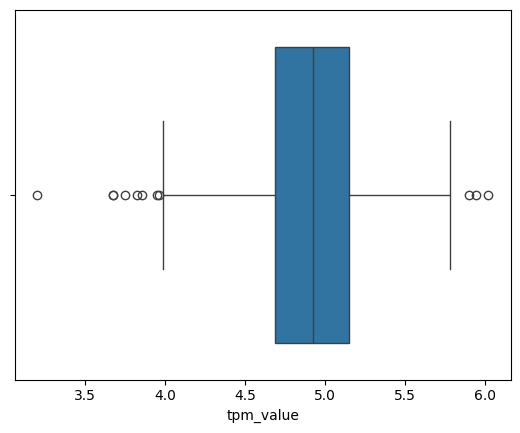

In [10]:
#Ελέγχω για outliers
for col in df.select_dtypes(include=['number']).columns:
    sns.boxplot(x=df[col])
    plt.show()

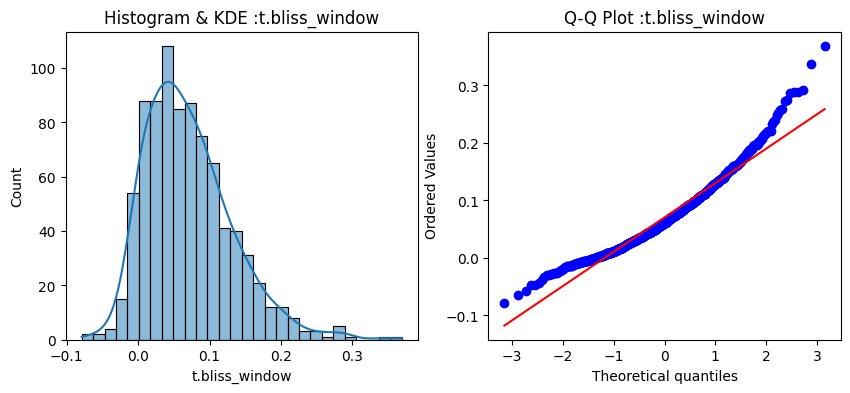

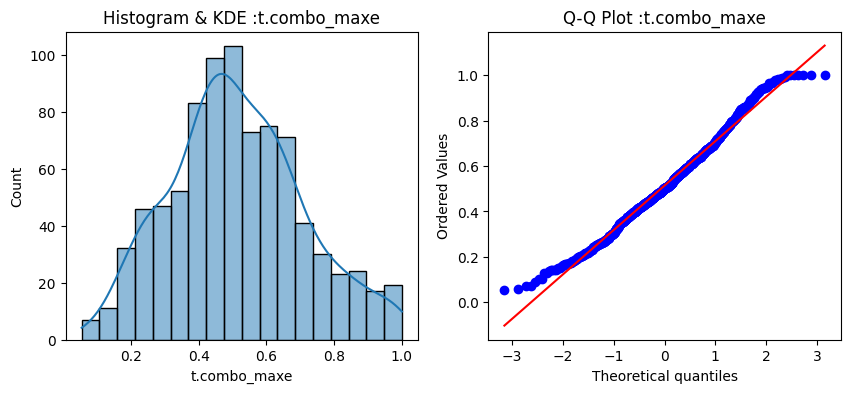

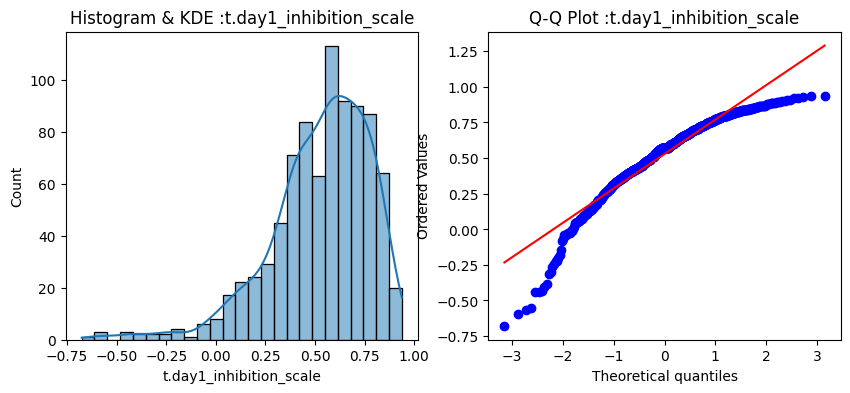

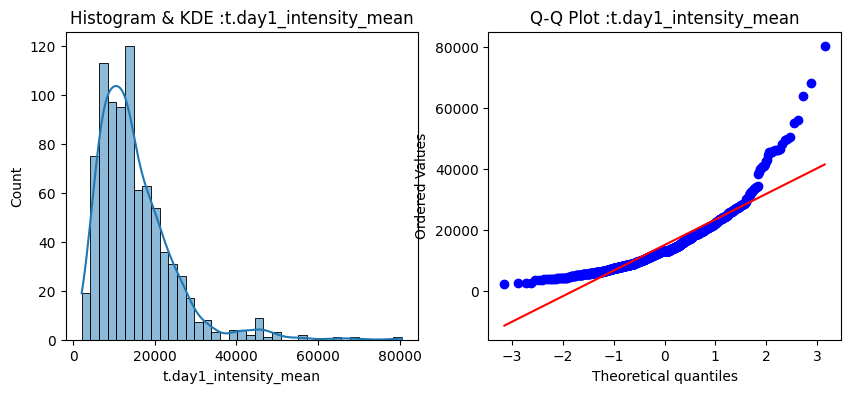

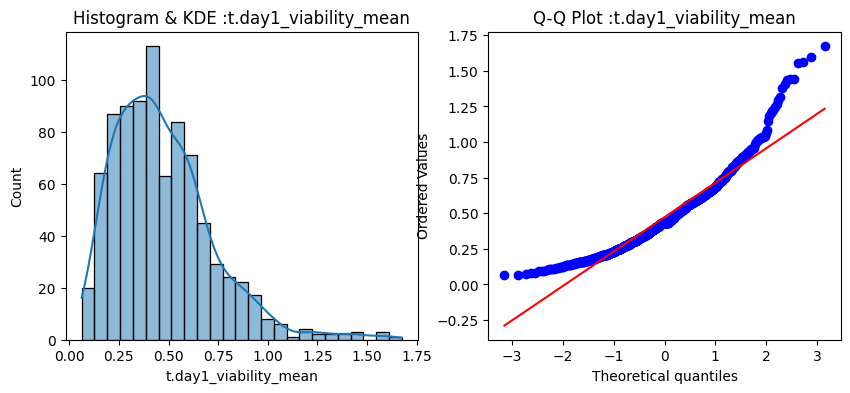

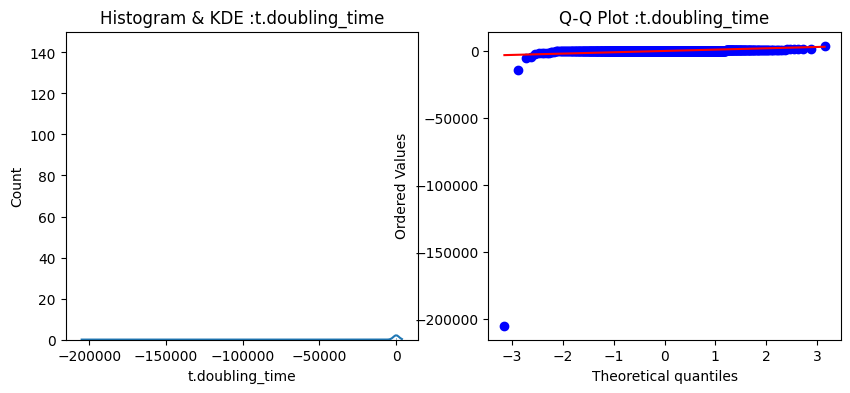

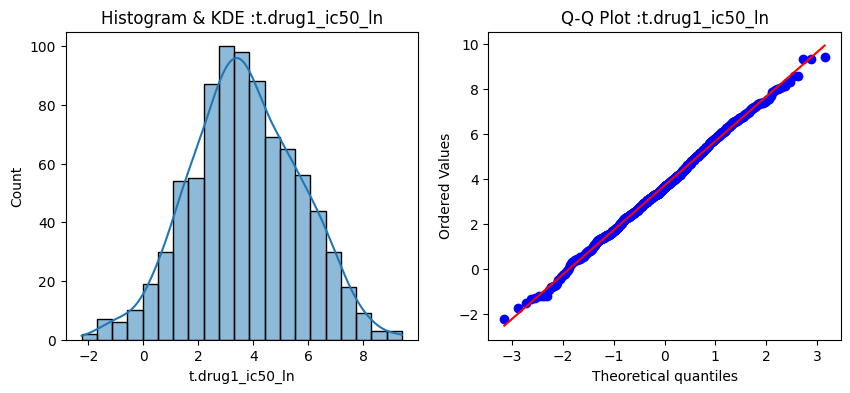

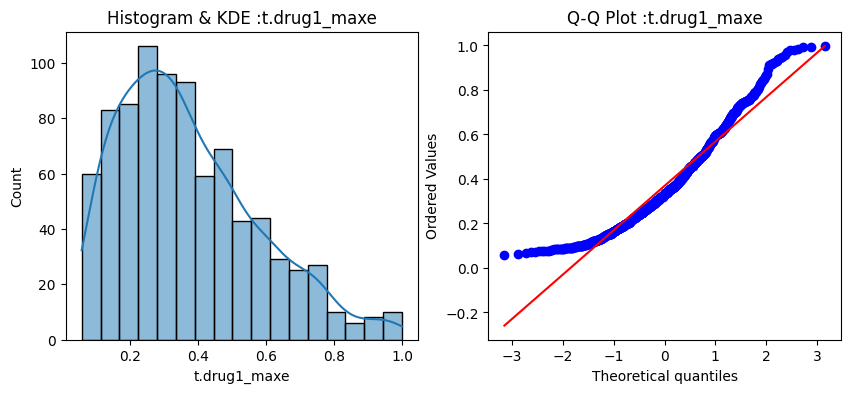

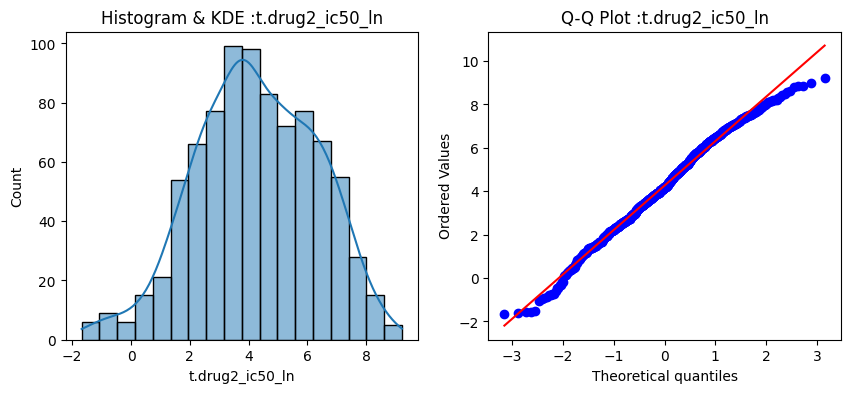

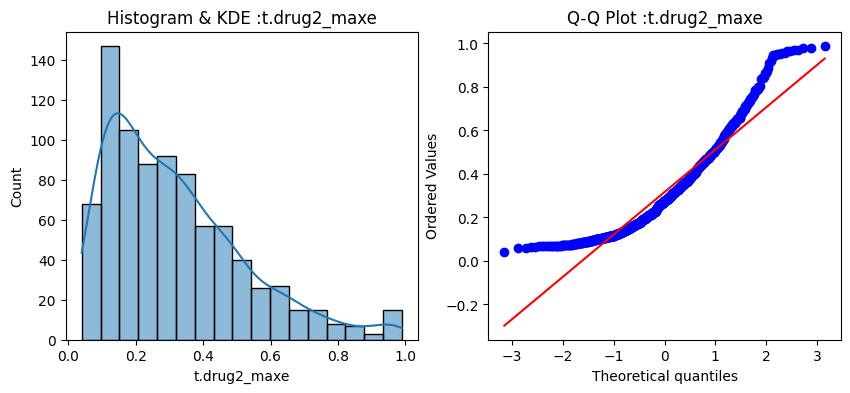

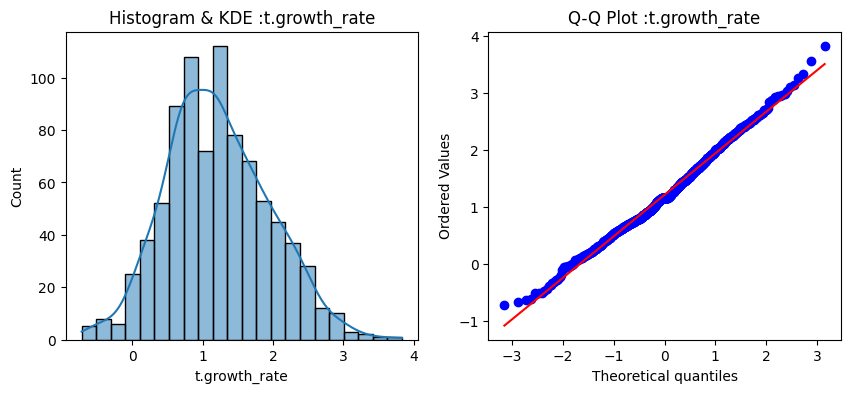

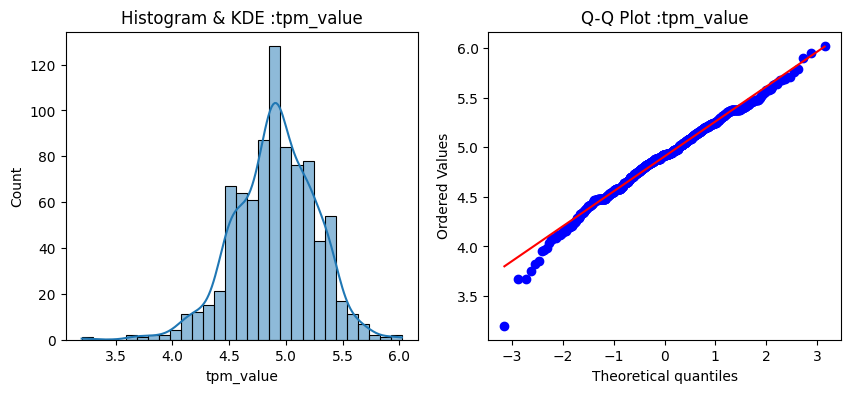

In [11]:
#Ελέγχω την κατανομη (κανονικότητα) των αριθμητικών στηλών
numeric_cols = df.select_dtypes(include=['number']).columns

for col in numeric_cols:

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Histogram & KDE :{col}')

    plt.subplot(1, 2, 2)
    stats.probplot(df[col].dropna(), dist="norm", plot=plt)
    plt.title(f'Q-Q Plot :{col}')

    plt.tight_layout
    plt.show

In [12]:
#Ελέγχω τη κανονικότητα με Shapiro Wilk test
normality_results = {}

for col in numeric_cols:
    data=df[col].dropna()
    stat, p=stats.shapiro(data)
    normality_results[col]= 'Normal' if p>0.05 else 'Not Normal'

for col, result in normality_results.items():
    print(f'{col}: {result}')

t.bliss_window: Not Normal
t.combo_maxe: Not Normal
t.day1_inhibition_scale: Not Normal
t.day1_intensity_mean: Not Normal
t.day1_viability_mean: Not Normal
t.doubling_time: Not Normal
t.drug1_ic50_ln: Normal
t.drug1_maxe: Not Normal
t.drug2_ic50_ln: Not Normal
t.drug2_maxe: Not Normal
t.growth_rate: Not Normal
tpm_value: Not Normal


In [13]:
#Κάνω scale τις αριθμητικές μου τιμές.
#Εφόσον δεν είναι κανονικά κατανεμημένα και εχω και καποια outliers, 
#χρησιμοποιούμε RobustScaler αντι για Normalization ή Standardization.

scaler = RobustScaler()

df_scaled = df.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df[numeric_cols])
df_scaled.head(2)

,t.bliss_window,t.combo_maxe,t.day1_inhibition_scale,t.day1_intensity_mean,t.day1_viability_mean,t.doubling_time,t.drug1_ic50_ln,t.drug1_maxe,t.drug2_ic50_ln,t.drug2_maxe,t.growth_rate,cellline_name,cancer_type,c.tissue,gene_name,tpm_value,pathway_name,drug_targeting_pathway,tpm_value_raw
0,0.128684,0.546636,-0.045646,-0.673093,0.045646,0.110726,-0.890523,1.012658,-0.104884,0.221689,-0.028261,42-MG-BA,Glioblastoma,Central Nervous System,"['ATR', 'WEE1', 'AURKB', 'ATM', 'BRCA2', 'ABRA...",-0.087819,"['PI3K/MTOR signaling', 'Cell cycle']","['Palbociclib', 'Capivasertib']","[3.2494, 4.7317, 6.0498, 5.0904, 2.5484, 2.403..."
1,-0.375355,-0.160556,-1.635435,0.635934,1.635435,14.469871,-0.397468,0.422753,-0.614549,0.791633,-1.086961,ALL-SIL,T-Lymphoblastic Leukemia,Haematopoietic and Lymphoid,"['ATR', 'WEE1', 'AURKB', 'ATM', 'BRCA2', 'ABRA...",0.893952,"['PI3K/MTOR signaling', 'Cell cycle']","['Palbociclib', 'Capivasertib']","[4.3125, 6.0199, 7.8476, 4.9887, 3.8135, 1.922..."


In [14]:
#Τωρα θα εξετασω τις κατηγορικες μου μεταβλητες.
#Για αρχη βλεπω ποσες διαοφρετικές κατηγορίες έχει η καθεμία.
num_categories=df_scaled['cellline_name'].nunique()
print(f'Αριθμός κατηγοριών στη "cellline_name": {num_categories}')

Αριθμός κατηγοριών στη "cellline_name": 717


In [15]:
num_categories=df_scaled['cancer_type'].nunique()
print(f'Αριθμός κατηγοριών στη "cancer_type": {num_categories}')

Αριθμός κατηγοριών στη "cancer_type": 42


In [16]:
num_categories=df_scaled['c.tissue'].nunique()
print(f'Αριθμός κατηγοριών στη "c.tissue": {num_categories}')

Αριθμός κατηγοριών στη "c.tissue": 26


In [17]:
#Κάνω drop και αλλες στηλες που κρατούσα απλά για reference κατα τη διαρκεια της διαδικασιας.
df_scaled.drop(columns=['gene_name', 'pathway_name', 'drug_targeting_pathway'], inplace=True)
df_scaled.head(2)

,t.bliss_window,t.combo_maxe,t.day1_inhibition_scale,t.day1_intensity_mean,t.day1_viability_mean,t.doubling_time,t.drug1_ic50_ln,t.drug1_maxe,t.drug2_ic50_ln,t.drug2_maxe,t.growth_rate,cellline_name,cancer_type,c.tissue,tpm_value,tpm_value_raw
0,0.128684,0.546636,-0.045646,-0.673093,0.045646,0.110726,-0.890523,1.012658,-0.104884,0.221689,-0.028261,42-MG-BA,Glioblastoma,Central Nervous System,-0.087819,"[3.2494, 4.7317, 6.0498, 5.0904, 2.5484, 2.403..."
1,-0.375355,-0.160556,-1.635435,0.635934,1.635435,14.469871,-0.397468,0.422753,-0.614549,0.791633,-1.086961,ALL-SIL,T-Lymphoblastic Leukemia,Haematopoietic and Lymphoid,0.893952,"[4.3125, 6.0199, 7.8476, 4.9887, 3.8135, 1.922..."


In [18]:
print(df_scaled.shape)

(853, 16)


In [19]:
df_scaled.head(2)

,t.bliss_window,t.combo_maxe,t.day1_inhibition_scale,t.day1_intensity_mean,t.day1_viability_mean,t.doubling_time,t.drug1_ic50_ln,t.drug1_maxe,t.drug2_ic50_ln,t.drug2_maxe,t.growth_rate,cellline_name,cancer_type,c.tissue,tpm_value,tpm_value_raw
0,0.128684,0.546636,-0.045646,-0.673093,0.045646,0.110726,-0.890523,1.012658,-0.104884,0.221689,-0.028261,42-MG-BA,Glioblastoma,Central Nervous System,-0.087819,"[3.2494, 4.7317, 6.0498, 5.0904, 2.5484, 2.403..."
1,-0.375355,-0.160556,-1.635435,0.635934,1.635435,14.469871,-0.397468,0.422753,-0.614549,0.791633,-1.086961,ALL-SIL,T-Lymphoblastic Leukemia,Haematopoietic and Lymphoid,0.893952,"[4.3125, 6.0199, 7.8476, 4.9887, 3.8135, 1.922..."


In [20]:
#One hot encode τις 'cancer_type' και 'c.tissue'.
#Για κάθε μοναδική κατηγορία δημιουργεί νέα δυαδική στήλη (0/1).
df_encoded = pd.get_dummies(df_scaled, columns=['cancer_type', 'c.tissue'], drop_first=True)

In [21]:
print(df_encoded.shape)

(853, 80)


In [22]:
#Target encode τη 'cellline_name', που έχει πολλές κατηγορίες.
#Αντικαθιστά κάθε κατηγορία με το μέσο όρο της target μεταβλητής (εδώ 't.bliss_window') για εκείνη την κατηγορία.
# Έχω στο νου μου ότι επειδη εχω πολλες κατηγοριες που πλησιαζει τον αριθμο των γραμμων μου
#αρα και το πληθος των bliss window, μπορεί να δημιουργήσει overfitting

df_encoded_twice = df_encoded.copy()

encoder= ce.TargetEncoder(cols=['cellline_name'])

df_encoded_twice['cellline_name'] = encoder.fit_transform(df_encoded['cellline_name'],df_encoded['t.bliss_window'])


In [23]:
print(df_encoded_twice.shape)
df_encoded_twice.head(5)

(853, 80)


,t.bliss_window,t.combo_maxe,t.day1_inhibition_scale,t.day1_intensity_mean,t.day1_viability_mean,t.doubling_time,t.drug1_ic50_ln,t.drug1_maxe,t.drug2_ic50_ln,t.drug2_maxe,...,c.tissue_Pancreas,c.tissue_Peripheral Nervous System,c.tissue_Prostate,c.tissue_Skin,c.tissue_Soft Tissue,c.tissue_Stomach,c.tissue_Testis,c.tissue_Thyroid,c.tissue_Uterus,c.tissue_Vulva
0,0.128684,0.546636,-0.045646,-0.673093,0.045646,0.110726,-0.890523,1.012658,-0.104884,0.221689,...,0,0,0,0,0,0,0,0,0,0
1,-0.375355,-0.160556,-1.635435,0.635934,1.635435,14.469871,-0.397468,0.422753,-0.614549,0.791633,...,0,0,0,0,0,0,0,0,0,0
2,0.522118,-0.109321,0.270514,-0.462638,-0.270514,-0.173775,0.570740,-0.338013,0.198349,-0.034275,...,0,0,0,0,0,0,0,0,0,0
3,0.430881,-0.149638,-0.010577,-0.538075,0.010577,0.075579,-0.123435,0.137505,-0.136698,0.132883,...,0,1,0,0,0,0,0,0,0,0
4,-0.882719,0.068377,-1.450411,0.469373,1.450411,6.603928,-0.431205,0.543267,0.387825,-0.208256,...,0,0,1,0,0,0,0,0,0,0


In [24]:
df_encoded_twice['cellline_name']

0      0.123836
1      0.058257
2      0.175026
3      0.163155
4     -0.007756
         ...   
848    0.122788
849    0.032539
850    0.158534
851    0.049579
852    0.049579
Name: cellline_name, Length: 853, dtype: float64

In [25]:
df_encoded_twice= df_encoded_twice.drop(columns=['tpm_value_raw']) #Αφαιρώ τη στήλη με τις λίστες
df_encoded_twice.columns

Index(['t.bliss_window', 't.combo_maxe', 't.day1_inhibition_scale',
       't.day1_intensity_mean', 't.day1_viability_mean', 't.doubling_time',
       't.drug1_ic50_ln', 't.drug1_maxe', 't.drug2_ic50_ln', 't.drug2_maxe',
       't.growth_rate', 'cellline_name', 'tpm_value',
       'cancer_type_B-Cell Non-Hodgkin's Lymphoma',
       'cancer_type_B-Lymphoblastic Leukemia',
       'cancer_type_Biliary Tract Carcinoma', 'cancer_type_Bladder Carcinoma',
       'cancer_type_Breast Carcinoma', 'cancer_type_Burkitt's Lymphoma',
       'cancer_type_Cervical Carcinoma', 'cancer_type_Chondrosarcoma',
       'cancer_type_Chronic Myelogenous Leukemia',
       'cancer_type_Colorectal Carcinoma', 'cancer_type_Endometrial Carcinoma',
       'cancer_type_Esophageal Adenocarcinoma',
       'cancer_type_Esophageal Squamous Cell Carcinoma',
       'cancer_type_Ewing's Sarcoma', 'cancer_type_Gastric Carcinoma',
       'cancer_type_Glioblastoma', 'cancer_type_Head and Neck Carcinoma',
       'cancer_type_He

In [177]:
#Αποθηκέυω το αρχείο locally

df_encoded_twice.to_csv('df_ml_model.csv', index=False)